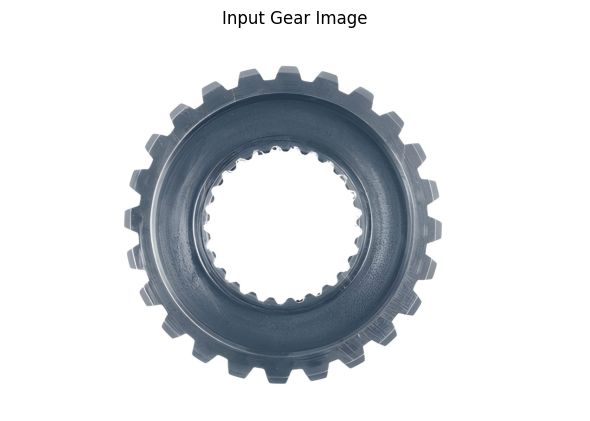

✅ Successfully loaded image: gear_10.jpg
📐 Image size: 2048×1364 pixels


In [57]:
import cv2
import numpy as np
import json
import math
import matplotlib.pyplot as plt
from pathlib import Path

# --- Paths (fixed) ---
PROJECT_ROOT = Path("../../SpurGear_Btechproject\Input_Images")
OUT_DIR = Path("Output")

# Ensure output directory exists
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Point to your image
IMG_PATH = PROJECT_ROOT / "gear_10.jpg"

# Verify image exists
assert IMG_PATH.exists(), f"Image not found at {IMG_PATH}. Please check the path."

# Read image
img = cv2.imread(str(IMG_PATH))
assert img is not None, f"Could not read image from {IMG_PATH}"

# Display
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6, 6))
plt.title("Input Gear Image")
plt.axis("off")
plt.imshow(img_rgb)
plt.tight_layout()
plt.show()

print(f"✅ Successfully loaded image: {IMG_PATH.name}")
print(f"📐 Image size: {img.shape[1]}×{img.shape[0]} pixels")


Thresholding Analysis:
  Center mean: 255.0 ± 0.0
  Border mean: 255.0 ± 0.0
  Intensity gap: 0.0
  Invert: False
  Method used: Otsu (thresh=177)


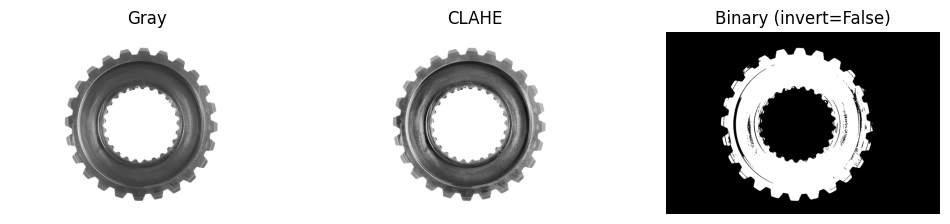

In [58]:
def auto_threshold(gray_img):
    """
    Enhanced thresholding for gear images with white background and grey gear
    """
    h, w = gray_img.shape
    
    # Adaptive region sampling based on image size
    center_size = min(40, h//8, w//8)  # Scale with image size
    border_size = min(30, h//10, w//10)
    
    # Sample center region (gear area)
    cx, cy = w//2, h//2
    center_region = gray_img[cy-center_size:cy+center_size, cx-center_size:cx+center_size]
    center_mean = np.mean(center_region)
    center_std = np.std(center_region)
    
    # Sample border regions (background area) - multiple samples for robustness
    border_samples = []
    # Top and bottom borders
    border_samples.extend([
        gray_img[:border_size, :].ravel(),
        gray_img[-border_size:, :].ravel()
    ])
    # Left and right borders  
    border_samples.extend([
        gray_img[:, :border_size].ravel(),
        gray_img[:, -border_size:].ravel()
    ])
    # Corner samples for extra robustness
    corner_size = border_size // 2
    border_samples.extend([
        gray_img[:corner_size, :corner_size].ravel(),  # Top-left
        gray_img[:corner_size, -corner_size:].ravel(), # Top-right
        gray_img[-corner_size:, :corner_size].ravel(), # Bottom-left
        gray_img[-corner_size:, -corner_size:].ravel() # Bottom-right
    ])
    
    # Combine all border samples and remove outliers
    all_border = np.concatenate(border_samples)
    # Remove extreme values (noise) using percentiles
    border_clean = all_border[(all_border >= np.percentile(all_border, 5)) & 
                             (all_border <= np.percentile(all_border, 95))]
    border_mean = np.mean(border_clean)
    border_std = np.std(border_clean)
    
    # Determine if gear is darker than background
    invert = center_mean < border_mean
    
    # Calculate optimal threshold based on the contrast
    intensity_gap = abs(border_mean - center_mean)
    
    # If there's good contrast, use a threshold between center and border
    if intensity_gap > 20:  # Good contrast
        manual_threshold = int((center_mean + border_mean) / 2)
        flag = cv2.THRESH_BINARY_INV if invert else cv2.THRESH_BINARY
        _, bin_manual = cv2.threshold(gray_img, manual_threshold, 255, flag)
    else:
        bin_manual = None
    
    # Always compute Otsu as fallback
    flag_otsu = cv2.THRESH_BINARY_INV if invert else cv2.THRESH_BINARY
    otsu_thresh, bin_otsu = cv2.threshold(gray_img, 0, 255, flag_otsu + cv2.THRESH_OTSU)
    
    # Choose the best threshold method
    if bin_manual is not None and intensity_gap > 30:
        # Use manual threshold for high contrast images
        final_binary = bin_manual
        method_used = f"Manual (thresh={manual_threshold})"
    else:
        # Use Otsu for low contrast images
        final_binary = bin_otsu
        method_used = f"Otsu (thresh={otsu_thresh:.0f})"
    
    # Post-processing: Remove small noise
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    final_binary = cv2.morphologyEx(final_binary, cv2.MORPH_OPEN, kernel, iterations=1)

    if not invert:
        final_binary = cv2.bitwise_not(final_binary)
    
    # Debug information
    print(f"Thresholding Analysis:")
    print(f"  Center mean: {center_mean:.1f} ± {center_std:.1f}")
    print(f"  Border mean: {border_mean:.1f} ± {border_std:.1f}")
    print(f"  Intensity gap: {intensity_gap:.1f}")
    print(f"  Invert: {invert}")
    print(f"  Method used: {method_used}")
    
    return final_binary, invert

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
gray_eq = clahe.apply(gray)

binary, was_inverted = auto_threshold(gray_eq)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("Gray"); plt.axis("off"); plt.imshow(gray, cmap="gray")
plt.subplot(1,3,2); plt.title("CLAHE"); plt.axis("off"); plt.imshow(gray_eq, cmap="gray")
plt.subplot(1,3,3); plt.title(f"Binary (invert={was_inverted})"); plt.axis("off"); plt.imshow(binary, cmap="gray")

✅ Detected pure white background — using direct masking


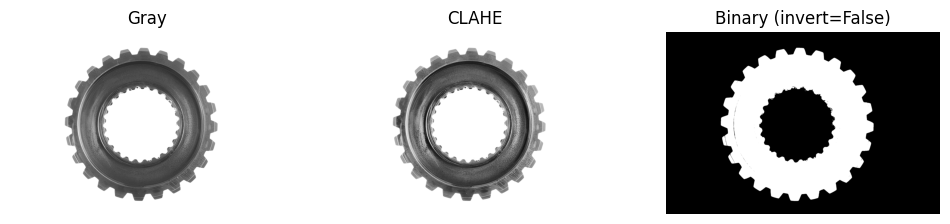

In [59]:
def auto_threshold(gray_img):
    """
    Enhanced thresholding for gear images with white background and grey gear
    """
    h, w = gray_img.shape
    
    # Adaptive region sampling based on image size
    center_size = min(40, h//8, w//8)  # Scale with image size
    border_size = min(30, h//10, w//10)
    
    # Sample center region (gear area)
    cx, cy = w//2, h//2
    center_region = gray_img[cy-center_size:cy+center_size, cx-center_size:cx+center_size]
    center_mean = np.mean(center_region)
    center_std = np.std(center_region)
    
    # Sample border regions (background area) - multiple samples for robustness
    border_samples = []
    border_samples.extend([
        gray_img[:border_size, :].ravel(),
        gray_img[-border_size:, :].ravel()
    ])
    border_samples.extend([
        gray_img[:, :border_size].ravel(),
        gray_img[:, -border_size:].ravel()
    ])
    corner_size = border_size // 2
    border_samples.extend([
        gray_img[:corner_size, :corner_size].ravel(),
        gray_img[:corner_size, -corner_size:].ravel(),
        gray_img[-corner_size:, :corner_size].ravel(),
        gray_img[-corner_size:, -corner_size:].ravel()
    ])
    
    all_border = np.concatenate(border_samples)
    border_clean = all_border[(all_border >= np.percentile(all_border, 5)) & 
                             (all_border <= np.percentile(all_border, 95))]
    border_mean = np.mean(border_clean)
    border_std = np.std(border_clean)
    
    invert = center_mean < border_mean
    intensity_gap = abs(border_mean - center_mean)
    
    if intensity_gap > 20:
        manual_threshold = int((center_mean + border_mean) / 2)
        flag = cv2.THRESH_BINARY_INV if invert else cv2.THRESH_BINARY
        _, bin_manual = cv2.threshold(gray_img, manual_threshold, 255, flag)
    else:
        bin_manual = None
    
    flag_otsu = cv2.THRESH_BINARY_INV if invert else cv2.THRESH_BINARY
    otsu_thresh, bin_otsu = cv2.threshold(gray_img, 0, 255, flag_otsu + cv2.THRESH_OTSU)
    
    if bin_manual is not None and intensity_gap > 30:
        final_binary = bin_manual
        method_used = f"Manual (thresh={manual_threshold})"
    else:
        final_binary = bin_otsu
        method_used = f"Otsu (thresh={otsu_thresh:.0f})"
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    final_binary = cv2.morphologyEx(final_binary, cv2.MORPH_OPEN, kernel, iterations=1)

    if not invert:
        final_binary = cv2.bitwise_not(final_binary)
    
    print(f"Thresholding Analysis:")
    print(f"  Center mean: {center_mean:.1f} ± {center_std:.1f}")
    print(f"  Border mean: {border_mean:.1f} ± {border_std:.1f}")
    print(f"  Intensity gap: {intensity_gap:.1f}")
    print(f"  Invert: {invert}")
    print(f"  Method used: {method_used}")
    
    return final_binary, invert


# ✅ NEW FALLBACK FUNCTION ADDED HERE (no changes to your original code)
def preprocess_with_fallback(img):
    tolerance = 240
    border = 20

    borders = np.concatenate([
        img[:border, :, :].reshape(-1,3),
        img[-border:, :, :].reshape(-1,3),
        img[:, :border, :].reshape(-1,3),
        img[:, -border:, :].reshape(-1,3),
    ])
    
    white_ratio = np.mean(np.all(borders >= tolerance, axis=1))
    
    if white_ratio > 0.85:
        print("✅ Detected pure white background — using direct masking")
        binary = np.where(np.all(img >= tolerance, axis=-1), 0, 255).astype(np.uint8)
        was_inverted = False
    else:
        print("⚙️ Complex lighting — using adaptive thresholding")
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        gray_eq = clahe.apply(gray)
        binary, was_inverted = auto_threshold(gray_eq)
    
    return binary, was_inverted


# ✅ SWITCHED CALL HERE — everything else stays the same
binary, was_inverted = preprocess_with_fallback(img)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("Gray"); plt.axis("off"); plt.imshow(gray, cmap="gray")
plt.subplot(1,3,2); plt.title("CLAHE"); plt.axis("off"); plt.imshow(gray_eq, cmap="gray")
plt.subplot(1,3,3); plt.title(f"Binary (invert={was_inverted})"); plt.axis("off"); plt.imshow(binary, cmap="gray")


In [60]:
# def auto_threshold(gray_img):
#     h, w = gray_img.shape
#     center = gray_img[h//2-20:h//2+20, w//2-20:w//2+20].mean()
#     border = np.concatenate([gray_img[:20,:].ravel(), gray_img[-20:,:].ravel(),
#                              gray_img[:, :20].ravel(), gray_img[:, -20:].ravel()]).mean()
#     invert = center < border
#     flag = cv2.THRESH_BINARY_INV if invert else cv2.THRESH_BINARY
#     _, bin_img = cv2.threshold(gray_img, 0, 255, flag + cv2.THRESH_OTSU)
#     return bin_img, invert

# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
# gray_eq = clahe.apply(gray)

# binary, was_inverted = auto_threshold(gray_eq)

# plt.figure(figsize=(12,4))
# plt.subplot(1,3,1); plt.title("Gray"); plt.axis("off"); plt.imshow(gray, cmap="gray")
# plt.subplot(1,3,2); plt.title("CLAHE"); plt.axis("off"); plt.imshow(gray_eq, cmap="gray")
# plt.subplot(1,3,3); plt.title(f"Otsu (invert={was_inverted})"); plt.axis("off"); plt.imshow(binary, cmap="gray")


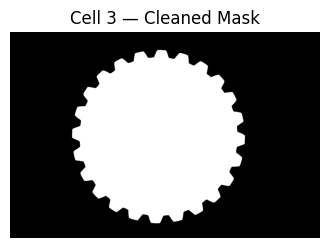

In [61]:
k3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
k5 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
mask = cv2.morphologyEx(binary, cv2.MORPH_OPEN, k3, iterations=1)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k5, iterations=2)

# keep largest connected component
cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
canvas = np.zeros_like(mask)
if cnts:
    cv2.drawContours(canvas, [max(cnts, key=cv2.contourArea)], -1, 255, -1)
    mask = canvas

cv2.imwrite(str("Output/gear_mask.png"), mask)
plt.figure(figsize=(4,4)); plt.title("Cell 3 — Cleaned Mask"); plt.axis("off"); plt.imshow(mask, cmap="gray")


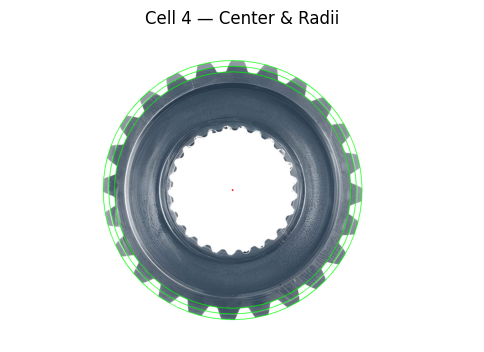

In [62]:
contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
hierarchy = hierarchy[0]
outer_idx = int(np.argmax([cv2.contourArea(c) for c in contours]))
outer = contours[outer_idx]

M = cv2.moments(mask, binaryImage=True)
cx, cy = M["m10"]/M["m00"], M["m01"]/M["m00"]

def robust_radius(contour, center, top_k=200, mode="max"):
    cx0, cy0 = center
    pts = contour[:,0,:]
    d = np.hypot(pts[:,0]-cx0, pts[:,1]-cy0)
    vals = np.sort(d); k = min(top_k, len(vals))
    return float(np.mean(vals[-k:] if mode=="max" else vals[:k]))

r_add = robust_radius(outer, (cx, cy), mode="max")
r_ded = robust_radius(outer, (cx, cy), mode="min")
r_pitch = 0.5*(r_add + r_ded)

# bore as largest child of outer (may be None if the photo doesn’t show it well)
child_idxs = [i for i,h in enumerate(hierarchy) if h[3]==outer_idx]
r_hole = None
if child_idxs:
    inner = max(child_idxs, key=lambda i: cv2.contourArea(contours[i]))
    r_hole = robust_radius(contours[inner], (cx, cy), mode="max")

diag = img.copy()
for r in [r_ded, r_pitch, r_add]: cv2.circle(diag, (int(cx),int(cy)), int(r), (0,255,0), 2)
if r_hole: cv2.circle(diag, (int(cx),int(cy)), int(r_hole), (255,0,0), 2)
cv2.circle(diag, (int(cx),int(cy)), 4, (0,0,255), -1)
cv2.imwrite(str("Output/gear_circles.png"), diag)

plt.figure(figsize=(6,6)); plt.title("Cell 4 — Center & Radii"); plt.axis("off")
plt.imshow(cv2.cvtColor(diag, cv2.COLOR_BGR2RGB))


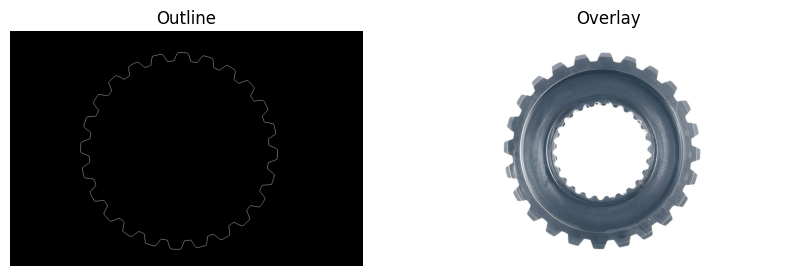

In [63]:
outline = cv2.morphologyEx(mask, cv2.MORPH_GRADIENT, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)))
_, outline = cv2.threshold(outline, 1, 255, cv2.THRESH_BINARY)

overlay = img.copy()
overlay[np.where(outline==255)] = (255,255,255)

cv2.imwrite(str("Output/gear_outline.png"), outline)
cv2.imwrite(str("Output/gear_overlay.png"), overlay)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.title("Outline"); plt.axis("off"); plt.imshow(outline, cmap="gray")
plt.subplot(1,2,2); plt.title("Overlay"); plt.axis("off"); plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))


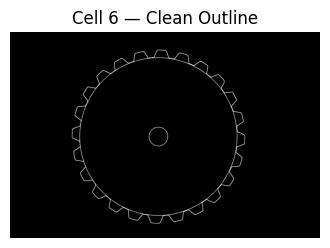

In [64]:
h, w = mask.shape[:2]
clean = np.zeros((h,w), dtype=np.uint8)
cv2.drawContours(clean, [outer], -1, 255, 2)                 
cv2.circle(clean, (int(cx),int(cy)), int(r_ded), 255, 2)     
cv2.circle(clean, (int(cx),int(cy)), int(r_hole or 0.12*r_ded), 255, 2)  

cv2.imwrite(str("Output/gear_outline_clean.png"), clean)
plt.figure(figsize=(4,4)); plt.title("Cell 6 — Clean Outline"); plt.axis("off"); plt.imshow(clean, cmap="gray")


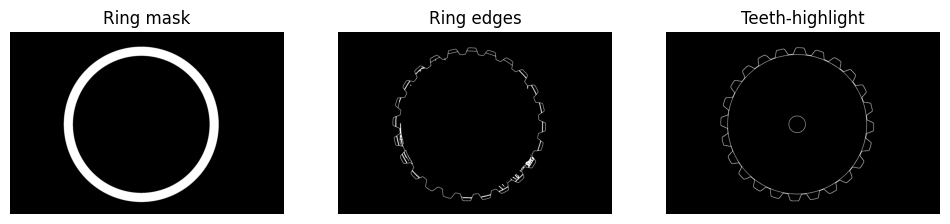

In [65]:
gray_blur = cv2.GaussianBlur(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), (5,5), 0)
edges = cv2.Canny(gray_blur, 50, 150)

yy, xx = np.indices(edges.shape)
dist = np.hypot(xx - cx, yy - cy)
MARGIN_IN, MARGIN_OUT = 10, 8  # widen if tips are truncated
ring = ((dist >= (r_ded - MARGIN_IN)) & (dist <= (r_add + MARGIN_OUT))).astype(np.uint8)*255

teeth_edges = cv2.bitwise_and(edges, ring)
k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
teeth_edges = cv2.morphologyEx(teeth_edges, cv2.MORPH_DILATE, k, iterations=1)
teeth_edges = cv2.morphologyEx(teeth_edges, cv2.MORPH_CLOSE, k, iterations=2)

cnts, _ = cv2.findContours(teeth_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
teeth_loop = np.zeros_like(teeth_edges)
if cnts:
    cv2.drawContours(teeth_loop, [max(cnts, key=cv2.contourArea)], -1, 255, 2)

teeth_final = np.zeros_like(teeth_loop)
teeth_final = cv2.bitwise_or(teeth_final, teeth_loop)
cv2.circle(teeth_final, (int(cx),int(cy)), int(r_ded), 255, 2)
cv2.circle(teeth_final, (int(cx),int(cy)), int(r_hole or 0.12*r_ded), 255, 2)

cv2.imwrite(str("Output/gear_teeth_outline.png"), teeth_final)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("Ring mask"); plt.axis("off"); plt.imshow(ring, cmap="gray")
plt.subplot(1,3,2); plt.title("Ring edges"); plt.axis("off"); plt.imshow(teeth_edges, cmap="gray")
plt.subplot(1,3,3); plt.title("Teeth-highlight"); plt.axis("off"); plt.imshow(teeth_final, cmap="gray")


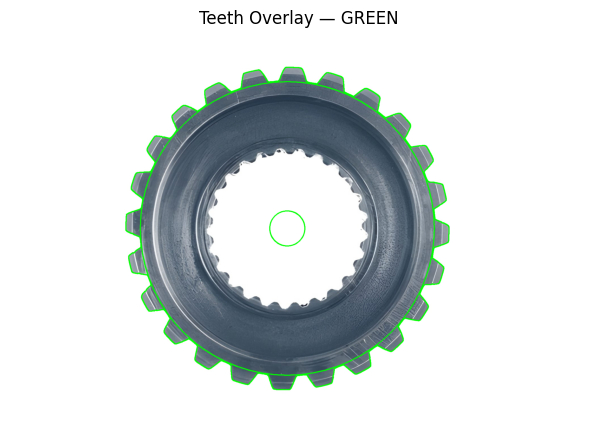

In [66]:
assert 'teeth_final' in globals() and 'img' in globals(), "Run through Cell 7 first."

def overlay_teeth_highlight(img_bgr, teeth_mask, color="green", thickness=2, alpha=1.0):
    color = color.lower()
    color_bgr = (0,255,0) if color == "green" else (255,255,255)

    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (max(1,thickness), max(1,thickness)))
    thick = cv2.dilate(teeth_mask, k, iterations=1)
    
    color_layer = np.full_like(img_bgr, color_bgr, dtype=np.uint8)
    m3 = (thick > 0).astype(np.float32)[..., None]
    out = (img_bgr.astype(np.float32)*(1 - alpha*m3) + color_layer.astype(np.float32)*(alpha*m3)).astype(np.uint8)
    return out

overlay_green = overlay_teeth_highlight(img, teeth_final, color="green", thickness=2, alpha=1.0)

# Ensure output directory exists
from pathlib import Path
Path("Output/gear_teeth_overlay_green.png").parent.mkdir(parents=True, exist_ok=True)
cv2.imwrite(str("Output/gear_teeth_overlay_green.png"), overlay_green)

plt.figure(figsize=(10,5))
plt.title("Teeth Overlay — GREEN")
plt.axis("off")
plt.imshow(cv2.cvtColor(overlay_green, cv2.COLOR_BGR2RGB))
plt.show()

In [67]:
def tooth_count_fft(outer_contour, cx, cy):
    pts = outer_contour[:,0,:]
    theta = np.mod(np.arctan2(pts[:,1]-cy, pts[:,0]-cx), 2*np.pi)
    r = np.hypot(pts[:,0]-cx, pts[:,1]-cy)
    idx = np.argsort(theta); theta, r = theta[idx], r[idx]
    theta2 = np.concatenate([theta, theta + 2*np.pi])
    r2 = np.concatenate([r, r])
    N = 4096
    tgrid = np.linspace(0, 2*np.pi, N, endpoint=False)
    rgrid = np.interp(tgrid, theta2, r2)
    kernel = np.ones(51)/51.0
    r_det = rgrid - np.convolve(rgrid, kernel, mode="same")
    F = np.fft.rfft(r_det)
    freqs = np.fft.rfftfreq(N, d=(2*np.pi/N))
    mask = (freqs >= 6) & (freqs <= 200)
    if not np.any(mask): return None
    return int(freqs[mask][np.argmax(np.abs(F[mask]))].round())

teeth_est = tooth_count_fft(outer, cx, cy)
m_px = (2.0 * r_pitch / teeth_est) if (teeth_est and teeth_est > 0) else None
p_circ_px = (math.pi * m_px) if m_px else None

results = {
    "center_px": [float(cx), float(cy)],
    "r_add_px": float(r_add),
    "r_ded_px": float(r_ded),
    "r_pitch_px": float(r_pitch),
    "r_hole_px": None if r_hole is None else float(r_hole),
    "teeth_estimate": None if teeth_est is None else int(teeth_est),
    "module_px": None if m_px is None else float(m_px),
    "circular_pitch_px": None if p_circ_px is None else float(p_circ_px),
}

# Ensure output directory exists
from pathlib import Path
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

with open(Path(OUT_DIR)/"gear_measurements.json", "w") as f:
    json.dump(results, f, indent=2)

print(json.dumps(results, indent=2))
print("\nSaved to:", Path(OUT_DIR).resolve())


{
  "center_px": [
    980.658035053515,
    695.2949819932015
  ],
  "r_add_px": 570.9972272799253,
  "r_ded_px": 520.8008688386299,
  "r_pitch_px": 545.8990480592776,
  "r_hole_px": null,
  "teeth_estimate": 11,
  "module_px": 99.2543723744141,
  "circular_pitch_px": 311.8168070881251
}

Saved to: D:\Sem-7\Btech project full and final\SpurGear_Btechproject\Notebook\Output


=== Comprehensive Gear Teeth Counting ===



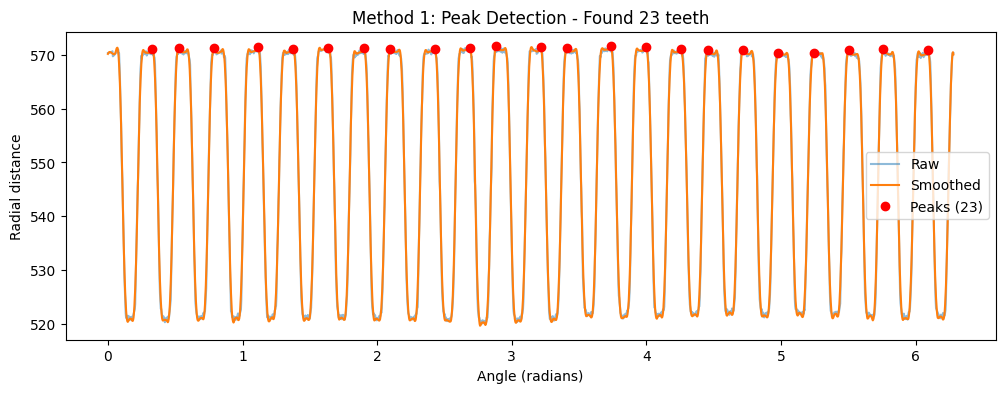

Method 1 - Peak Detection: 23 teeth
Method 2: Found 24 significant convexity defects
  Defect 0: distance = 46.72 pixels
  Defect 1: distance = 46.82 pixels
  Defect 2: distance = 47.14 pixels
  Defect 3: distance = 47.58 pixels
  Defect 4: distance = 47.09 pixels
  Defect 5: distance = 48.40 pixels
  Defect 6: distance = 48.31 pixels
  Defect 7: distance = 48.86 pixels
  Defect 8: distance = 47.94 pixels
  Defect 9: distance = 47.34 pixels
  Defect 10: distance = 47.88 pixels
  Defect 11: distance = 47.49 pixels
  Defect 12: distance = 47.73 pixels
  Defect 13: distance = 48.04 pixels
  Defect 14: distance = 47.54 pixels
  Defect 15: distance = 47.39 pixels
  Defect 16: distance = 48.04 pixels
  Defect 17: distance = 47.86 pixels
  Defect 18: distance = 47.26 pixels
  Defect 19: distance = 47.30 pixels
  Defect 20: distance = 46.86 pixels
  Defect 21: distance = 46.46 pixels
  Defect 22: distance = 45.98 pixels
  Defect 23: distance = 46.88 pixels
Method 2 - Convexity Defects: 24 teet

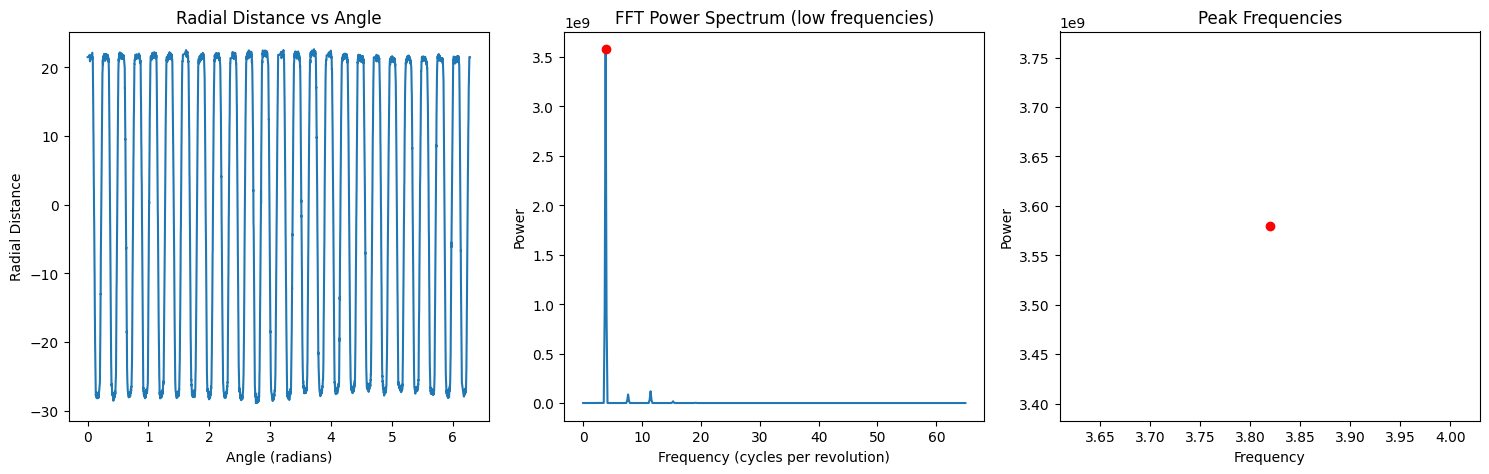

Method 3 - Improved FFT: 4 teeth
Method 4 failed: OpenCV(4.8.0) :-1: error: (-5:Bad argument) in function 'pointPolygonTest'
> Overload resolution failed:
>  - Can't parse 'pt'. Sequence item with index 0 has a wrong type
>  - Can't parse 'pt'. Sequence item with index 0 has a wrong type

Method 5: Polygon approximation with epsilon=50.79
Original contour points: 4329
Approximated vertices: 8
Method 5 - Polygon Approximation: 8 vertices

📊 MEDIAN ESTIMATE: 15 teeth
All estimates: [23, 24, 4, 8]

FINAL RESULT: 15 teeth detected
{
  "center_px": [
    980.658035053515,
    695.2949819932015
  ],
  "r_add_px": 570.9972272799253,
  "r_ded_px": 520.8008688386299,
  "r_pitch_px": 545.8990480592776,
  "r_hole_px": null,
  "teeth_estimate": 15,
  "module_px": 72.78653974123701,
  "circular_pitch_px": 228.6656585312917,
  "method_details": {
    "Peak Detection": 23,
    "Convexity Defects": 24,
    "Improved FFT": 4,
    "Corner Detection": null,
    "Polygon Approximation": 8
  }
}


In [68]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter
from scipy import ndimage
import math

def method1_peak_detection(outer_contour, cx, cy, plot_debug=False):
    """
    Method 1: Peak detection in radial distance signal
    """
    pts = outer_contour[:,0,:]
    theta = np.mod(np.arctan2(pts[:,1]-cy, pts[:,0]-cx), 2*np.pi)
    r = np.hypot(pts[:,0]-cx, pts[:,1]-cy)
    
    # Sort by angle
    idx = np.argsort(theta)
    theta_sorted, r_sorted = theta[idx], r[idx]
    
    # Interpolate to uniform grid
    N = 2048
    tgrid = np.linspace(0, 2*np.pi, N, endpoint=False)
    rgrid = np.interp(tgrid, theta_sorted, r_sorted)
    
    # Smooth the signal
    rgrid_smooth = savgol_filter(rgrid, window_length=21, polyorder=3)
    
    # Find peaks (teeth tips)
    peaks, properties = find_peaks(rgrid_smooth, 
                                 distance=N//100,  # minimum distance between peaks
                                 prominence=np.std(rgrid_smooth)*0.5)
    
    if plot_debug:
        plt.figure(figsize=(12, 4))
        plt.plot(tgrid, rgrid, alpha=0.5, label='Raw')
        plt.plot(tgrid, rgrid_smooth, label='Smoothed')
        plt.plot(tgrid[peaks], rgrid_smooth[peaks], 'ro', label=f'Peaks ({len(peaks)})')
        plt.xlabel('Angle (radians)')
        plt.ylabel('Radial distance')
        plt.title(f'Method 1: Peak Detection - Found {len(peaks)} teeth')
        plt.legend()
        plt.show()
    
    return len(peaks)

def method2_convexity_defects(outer_contour, plot_debug=False):
    """
    Method 2: Count convexity defects (tooth valleys)
    """
    # Get convex hull
    hull = cv2.convexHull(outer_contour, returnPoints=False)
    
    # Get convexity defects
    defects = cv2.convexityDefects(outer_contour, hull)
    
    if defects is None:
        return 0
    
    # Filter significant defects
    significant_defects = []
    for i in range(defects.shape[0]):
        s, e, f, d = defects[i, 0]
        # d is the distance from the farthest point to the hull (in 256ths of pixel)
        distance = d / 256.0
        if distance > 5:  # Adjust threshold as needed
            significant_defects.append((s, e, f, d))
    
    if plot_debug:
        print(f"Method 2: Found {len(significant_defects)} significant convexity defects")
        for i, (s, e, f, d) in enumerate(significant_defects):
            print(f"  Defect {i}: distance = {d/256.0:.2f} pixels")
    
    return len(significant_defects)

def method3_improved_fft(outer_contour, cx, cy, plot_debug=False):
    """
    Method 3: Improved FFT with better preprocessing and harmonic analysis
    """
    pts = outer_contour[:,0,:]
    theta = np.mod(np.arctan2(pts[:,1]-cy, pts[:,0]-cx), 2*np.pi)
    r = np.hypot(pts[:,0]-cx, pts[:,1]-cy)
    
    # Sort by angle
    idx = np.argsort(theta)
    theta_sorted, r_sorted = theta[idx], r[idx]
    
    # Interpolate to uniform grid with higher resolution
    N = 8192
    tgrid = np.linspace(0, 2*np.pi, N, endpoint=False)
    rgrid = np.interp(tgrid, theta_sorted, r_sorted)
    
    # Remove DC component and apply windowing
    rgrid = rgrid - np.mean(rgrid)
    window = np.hanning(N)
    rgrid_windowed = rgrid * window
    
    # Compute FFT
    F = np.fft.rfft(rgrid_windowed)
    freqs = np.fft.rfftfreq(N, d=(2*np.pi/N))
    power = np.abs(F)**2
    
    # Find peaks in frequency domain
    freq_peaks, _ = find_peaks(power, height=np.max(power)*0.1)
    
    if plot_debug:
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.plot(tgrid, rgrid)
        plt.title('Radial Distance vs Angle')
        plt.xlabel('Angle (radians)')
        plt.ylabel('Radial Distance')
        
        plt.subplot(1, 3, 2)
        plt.plot(freqs[:len(freqs)//10], power[:len(power)//10])
        plt.plot(freqs[freq_peaks], power[freq_peaks], 'ro')
        plt.title('FFT Power Spectrum (low frequencies)')
        plt.xlabel('Frequency (cycles per revolution)')
        plt.ylabel('Power')
        
        plt.subplot(1, 3, 3)
        plt.plot(freqs[freq_peaks], power[freq_peaks], 'ro-')
        plt.title('Peak Frequencies')
        plt.xlabel('Frequency')
        plt.ylabel('Power')
        
        plt.tight_layout()
        plt.show()
    
    # Look for the fundamental frequency (exclude DC at index 0)
    valid_peaks = freq_peaks[freq_peaks > 0]
    if len(valid_peaks) == 0:
        return None
    
    # Find the peak with maximum power (likely fundamental)
    max_power_idx = valid_peaks[np.argmax(power[valid_peaks])]
    fundamental_freq = freqs[max_power_idx]
    
    return int(round(fundamental_freq))

def method4_corner_detection(img_gray, outer_contour, plot_debug=False):
    """
    Method 4: Harris corner detection on gear teeth
    """
    # Create mask for the gear
    mask = np.zeros_like(img_gray)
    cv2.fillPoly(mask, [outer_contour], 255)
    
    # Apply Harris corner detection
    corners = cv2.cornerHarris(img_gray, blockSize=2, ksize=3, k=0.04)
    corners = corners * mask  # Apply mask
    
    # Find corner peaks
    corner_threshold = 0.01 * corners.max()
    corner_points = np.where(corners > corner_threshold)
    
    # Filter corners that are on the outer boundary
    boundary_corners = []
    for i in range(len(corner_points[0])):
        y, x = corner_points[0][i], corner_points[1][i]
        # Check if point is close to the contour
        dist = cv2.pointPolygonTest(outer_contour, (x, y), True)
        if abs(dist) < 10:  # Within 10 pixels of boundary
            boundary_corners.append((x, y))
    
    if plot_debug:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(corners, cmap='hot')
        plt.title('Harris Corners')
        
        plt.subplot(1, 2, 2)
        plt.imshow(img_gray, cmap='gray')
        if boundary_corners:
            bc = np.array(boundary_corners)
            plt.plot(bc[:, 0], bc[:, 1], 'ro', markersize=3)
        plt.title(f'Boundary Corners ({len(boundary_corners)})')
        plt.show()
    
    # Estimate teeth count (each tooth typically has 2 corners)
    return len(boundary_corners) // 2 if len(boundary_corners) > 0 else 0

def method5_contour_approximation(outer_contour, plot_debug=False):
    """
    Method 5: Polygon approximation to count vertices (teeth)
    """
    # Approximate contour with polygon
    epsilon_factor = 0.01  # Adjust this value
    epsilon = epsilon_factor * cv2.arcLength(outer_contour, True)
    approx = cv2.approxPolyDP(outer_contour, epsilon, True)
    
    if plot_debug:
        print(f"Method 5: Polygon approximation with epsilon={epsilon:.2f}")
        print(f"Original contour points: {len(outer_contour)}")
        print(f"Approximated vertices: {len(approx)}")
    
    return len(approx)

def comprehensive_tooth_count(img_gray, outer_contour, cx, cy, plot_debug=False):
    """
    Run all methods and return consensus result
    """
    print("=== Comprehensive Gear Teeth Counting ===\n")
    
    results = {}
    
    # Method 1: Peak detection
    try:
        count1 = method1_peak_detection(outer_contour, cx, cy, plot_debug)
        results['Peak Detection'] = count1
        print(f"Method 1 - Peak Detection: {count1} teeth")
    except Exception as e:
        print(f"Method 1 failed: {e}")
        results['Peak Detection'] = None
    
    # Method 2: Convexity defects
    try:
        count2 = method2_convexity_defects(outer_contour, plot_debug)
        results['Convexity Defects'] = count2
        print(f"Method 2 - Convexity Defects: {count2} teeth")
    except Exception as e:
        print(f"Method 2 failed: {e}")
        results['Convexity Defects'] = None
    
    # Method 3: Improved FFT
    try:
        count3 = method3_improved_fft(outer_contour, cx, cy, plot_debug)
        results['Improved FFT'] = count3
        print(f"Method 3 - Improved FFT: {count3} teeth")
    except Exception as e:
        print(f"Method 3 failed: {e}")
        results['Improved FFT'] = None
    
    # Method 4: Corner detection
    try:
        count4 = method4_corner_detection(img_gray, outer_contour, plot_debug)
        results['Corner Detection'] = count4
        print(f"Method 4 - Corner Detection: {count4} teeth")
    except Exception as e:
        print(f"Method 4 failed: {e}")
        results['Corner Detection'] = None
    
    # Method 5: Polygon approximation
    try:
        count5 = method5_contour_approximation(outer_contour, plot_debug)
        results['Polygon Approximation'] = count5
        print(f"Method 5 - Polygon Approximation: {count5} vertices")
    except Exception as e:
        print(f"Method 5 failed: {e}")
        results['Polygon Approximation'] = None
    
    # Find consensus
    valid_counts = [v for v in results.values() if v is not None and v > 0]
    
    if valid_counts:
        # Use the most common result, or median if no consensus
        from collections import Counter
        count_freq = Counter(valid_counts)
        most_common = count_freq.most_common(1)[0]
        
        if most_common[1] > 1:  # If there's a consensus
            consensus = most_common[0]
            print(f"\n✅ CONSENSUS: {consensus} teeth (appears {most_common[1]} times)")
        else:
            consensus = int(np.median(valid_counts))
            print(f"\n📊 MEDIAN ESTIMATE: {consensus} teeth")
            print(f"All estimates: {valid_counts}")
        
        return consensus, results
    else:
        print("\n❌ No valid results obtained")
        return None, results

# Replace your existing tooth_count_fft function with this:

# Convert your color image to grayscale if needed
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img

# Run comprehensive tooth counting
teeth_est, method_results = comprehensive_tooth_count(img_gray, outer, cx, cy, plot_debug=True)

# Update your calculations
m_px = (2.0 * r_pitch / teeth_est) if (teeth_est and teeth_est > 0) else None
p_circ_px = (math.pi * m_px) if m_px else None

# Update your results dictionary
results = {
    "center_px": [float(cx), float(cy)],
    "r_add_px": float(r_add),
    "r_ded_px": float(r_ded),
    "r_pitch_px": float(r_pitch),
    "r_hole_px": None if r_hole is None else float(r_hole),
    "teeth_estimate": None if teeth_est is None else int(teeth_est),
    "module_px": None if m_px is None else float(m_px),
    "circular_pitch_px": None if p_circ_px is None else float(p_circ_px),
    "method_details": method_results  # Store individual method results
}

print("\n" + "="*50)
print(f"FINAL RESULT: {teeth_est} teeth detected")
print("="*50)
print(json.dumps(results, indent=2))

=== Comprehensive Gear Teeth Counting ===



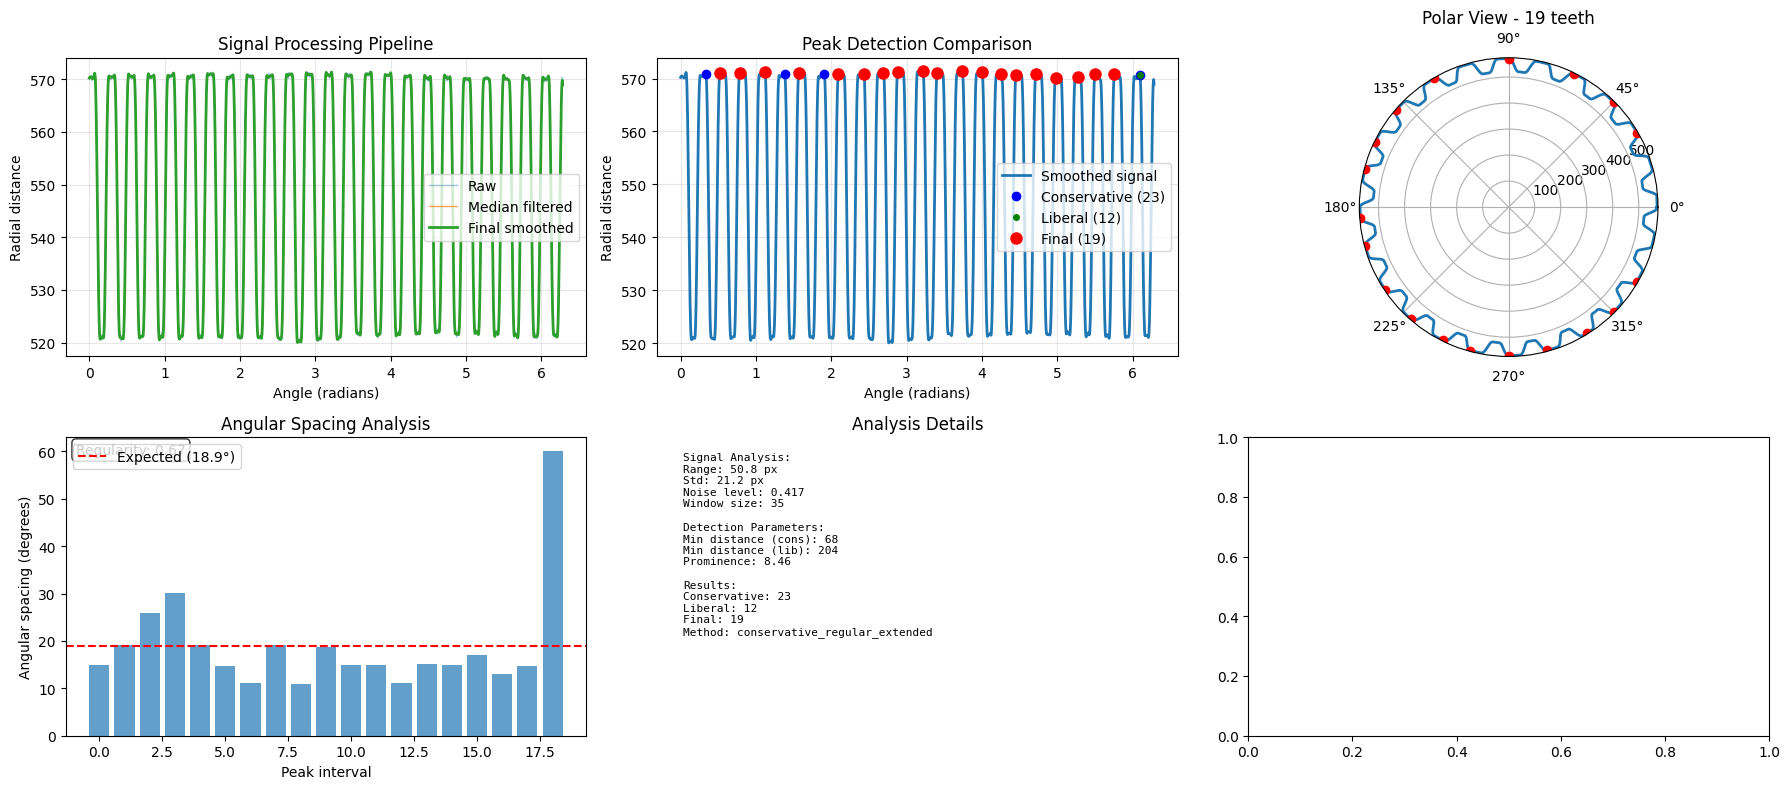


=== ROBUST PEAK DETECTION RESULTS ===
Signal characteristics: Range=50.8px, Std=21.2px, Noise=0.417
Detection method used: conservative_regular_extended
Conservative peaks: 23 (regular: True)
Liberal peaks: 12 (regular: False)
Final result: 19 teeth
Method 1 - Peak Detection: 19 teeth

📊 MEDIAN ESTIMATE: 19 teeth
All estimates: [19]

FINAL RESULT: 19 teeth detected
{
  "center_px": [
    980.658035053515,
    695.2949819932015
  ],
  "r_add_px": 570.9972272799253,
  "r_ded_px": 520.8008688386299,
  "r_pitch_px": 545.8990480592776,
  "r_hole_px": null,
  "teeth_estimate": 19,
  "module_px": 57.46305769045027,
  "circular_pitch_px": 180.52551989312502,
  "method_details": {
    "Peak Detection": 19
  }
}


In [69]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter
from scipy import ndimage
import math

def method1_peak_detection(outer_contour, cx, cy, plot_debug=False):
    """
    Method 1: Robust peak detection in radial distance signal
    """
    pts = outer_contour[:,0,:]
    theta = np.mod(np.arctan2(pts[:,1]-cy, pts[:,0]-cx), 2*np.pi)
    r = np.hypot(pts[:,0]-cx, pts[:,1]-cy)
    
    # Sort by angle
    idx = np.argsort(theta)
    theta_sorted, r_sorted = theta[idx], r[idx]
    
    # Interpolate to uniform grid with higher resolution for better accuracy
    N = 4096  # Increased resolution
    tgrid = np.linspace(0, 2*np.pi, N, endpoint=False)
    rgrid = np.interp(tgrid, theta_sorted, r_sorted)
    
    # Multi-stage robust filtering
    # Stage 1: Remove DC component to handle lighting variations
    rgrid_centered = rgrid - np.mean(rgrid)
    
    # Stage 2: Apply median filter to remove impulse noise
    from scipy.signal import medfilt
    rgrid_median = medfilt(rgrid_centered, kernel_size=15) + np.mean(rgrid)
    
    # Stage 3: Adaptive smoothing based on signal characteristics
    signal_std = np.std(rgrid_median)
    signal_range = np.max(rgrid_median) - np.min(rgrid_median)
    
    # Adaptive window size - smaller for cleaner signals, larger for noisy ones
    noise_level = signal_std / signal_range if signal_range > 0 else 0.1
    if noise_level < 0.05:
        window_length = 15  # Clean signal
    elif noise_level < 0.1:
        window_length = 25  # Moderate noise
    else:
        window_length = 35  # Noisy signal
    
    # Ensure odd window length
    if window_length % 2 == 0:
        window_length += 1
    
    rgrid_smooth = savgol_filter(rgrid_median, window_length=window_length, polyorder=3)
    
    # Adaptive peak detection parameters
    # Calculate expected minimum distance between teeth
    expected_teeth_range = (20, 60)  # Reasonable range for gear teeth
    min_distance_conservative = N // expected_teeth_range[1]  # For max teeth
    min_distance_liberal = N // expected_teeth_range[0]      # For min teeth
    
    # Adaptive prominence threshold
    prominence_base = np.std(rgrid_smooth - np.mean(rgrid_smooth))
    prominence_threshold = prominence_base * 0.4  # More conservative than 0.5
    
    # Primary peak detection with conservative parameters
    peaks_conservative, props_conservative = find_peaks(
        rgrid_smooth,
        distance=min_distance_conservative,
        prominence=prominence_threshold,
        width=2
    )
    
    # Secondary peak detection with liberal parameters
    peaks_liberal, props_liberal = find_peaks(
        rgrid_smooth,
        distance=min_distance_liberal,
        prominence=prominence_threshold * 0.6,
        width=1
    )
    
    # Validate peaks by checking regularity (gear teeth should be evenly spaced)
    def validate_peaks_regularity(peaks, tolerance=0.3):
        if len(peaks) < 4:  # Need sufficient peaks for validation
            return peaks, False
            
        # Calculate angular positions
        peak_angles = tgrid[peaks]
        
        # Calculate angular differences (handle wrap-around)
        angles_sorted = np.sort(peak_angles)
        angle_diffs = np.diff(angles_sorted)
        angle_diffs = np.append(angle_diffs, 2*np.pi - (angles_sorted[-1] - angles_sorted[0]))
        
        # Check regularity
        expected_spacing = 2 * np.pi / len(peaks)
        deviations = np.abs(angle_diffs - expected_spacing) / expected_spacing
        
        # Filter out peaks that create irregular spacing
        regular_peaks = []
        for i, peak in enumerate(peaks):
            if i < len(deviations) and deviations[i] < tolerance:
                regular_peaks.append(peak)
        
        is_regular = len(regular_peaks) > len(peaks) * 0.8  # Keep if >80% are regular
        return np.array(regular_peaks) if is_regular else peaks, is_regular
    
    # Validate both peak sets
    peaks_conservative_valid, conservative_regular = validate_peaks_regularity(peaks_conservative)
    peaks_liberal_valid, liberal_regular = validate_peaks_regularity(peaks_liberal)
    
    # Choose the best result based on validation and expected range
    conservative_count = len(peaks_conservative_valid)
    liberal_count = len(peaks_liberal_valid)
    
    # Decision logic
    if conservative_regular and expected_teeth_range[0] <= conservative_count <= expected_teeth_range[1]:
        # Conservative result is regular and in expected range
        final_peaks = peaks_conservative_valid
        detection_method = "conservative_regular"
    elif liberal_regular and expected_teeth_range[0] <= liberal_count <= expected_teeth_range[1]:
        # Liberal result is regular and in expected range
        final_peaks = peaks_liberal_valid
        detection_method = "liberal_regular"
    elif conservative_regular:
        # Conservative is regular but outside range - trust regularity
        final_peaks = peaks_conservative_valid
        detection_method = "conservative_regular_extended"
    elif liberal_regular:
        # Liberal is regular but outside range - trust regularity
        final_peaks = peaks_liberal_valid
        detection_method = "liberal_regular_extended"
    else:
        # Neither is regular - choose the one closer to expected range
        if abs(conservative_count - 30) < abs(liberal_count - 30):  # Assuming target is ~30
            final_peaks = peaks_conservative
            detection_method = "conservative_fallback"
        else:
            final_peaks = peaks_liberal
            detection_method = "liberal_fallback"
    
    if plot_debug:
        plt.figure(figsize=(18, 8))
        
        # Plot 1: Signal processing pipeline
        plt.subplot(2, 3, 1)
        plt.plot(tgrid, rgrid, alpha=0.4, label='Raw', linewidth=1)
        plt.plot(tgrid, rgrid_median, alpha=0.7, label='Median filtered', linewidth=1)
        plt.plot(tgrid, rgrid_smooth, label='Final smoothed', linewidth=2)
        plt.xlabel('Angle (radians)')
        plt.ylabel('Radial distance')
        plt.title('Signal Processing Pipeline')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot 2: Peak detection comparison
        plt.subplot(2, 3, 2)
        plt.plot(tgrid, rgrid_smooth, label='Smoothed signal', linewidth=2)
        plt.plot(tgrid[peaks_conservative], rgrid_smooth[peaks_conservative], 'bo', 
                markersize=6, label=f'Conservative ({len(peaks_conservative)})')
        plt.plot(tgrid[peaks_liberal], rgrid_smooth[peaks_liberal], 'go', 
                markersize=4, label=f'Liberal ({len(peaks_liberal)})')
        plt.plot(tgrid[final_peaks], rgrid_smooth[final_peaks], 'ro', 
                markersize=8, label=f'Final ({len(final_peaks)})')
        plt.xlabel('Angle (radians)')
        plt.ylabel('Radial distance')
        plt.title('Peak Detection Comparison')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot 3: Polar view
        plt.subplot(2, 3, 3, projection='polar')
        plt.plot(tgrid, rgrid_smooth, linewidth=2)
        plt.plot(tgrid[final_peaks], rgrid_smooth[final_peaks], 'ro', markersize=6)
        plt.title(f'Polar View - {len(final_peaks)} teeth')
        
        # Plot 4: Angular spacing analysis
        plt.subplot(2, 3, 4)
        if len(final_peaks) > 1:
            peak_angles = tgrid[final_peaks] * 180 / np.pi
            angles_sorted = np.sort(peak_angles)
            angular_spacing = np.diff(angles_sorted)
            angular_spacing = np.append(angular_spacing, 360 - (angles_sorted[-1] - angles_sorted[0]))
            
            expected_spacing = 360 / len(final_peaks)
            
            plt.bar(range(len(angular_spacing)), angular_spacing, alpha=0.7)
            plt.axhline(y=expected_spacing, color='r', linestyle='--', 
                       label=f'Expected ({expected_spacing:.1f}°)')
            plt.xlabel('Peak interval')
            plt.ylabel('Angular spacing (degrees)')
            plt.title('Angular Spacing Analysis')
            plt.legend()
            
            # Calculate regularity score
            deviations = np.abs(angular_spacing - expected_spacing) / expected_spacing
            regularity_score = 1.0 - np.mean(deviations)
            plt.text(0.02, 0.98, f'Regularity: {regularity_score:.2f}', 
                    transform=plt.gca().transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Plot 5: Signal statistics
        plt.subplot(2, 3, 5)
        stats_text = f"""Signal Analysis:
Range: {signal_range:.1f} px
Std: {signal_std:.1f} px
Noise level: {noise_level:.3f}
Window size: {window_length}

Detection Parameters:
Min distance (cons): {min_distance_conservative}
Min distance (lib): {min_distance_liberal}  
Prominence: {prominence_threshold:.2f}

Results:
Conservative: {len(peaks_conservative)}
Liberal: {len(peaks_liberal)}
Final: {len(final_peaks)}
Method: {detection_method}"""
        
        plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes,
                verticalalignment='top', fontfamily='monospace', fontsize=8)
        plt.axis('off')
        plt.title('Analysis Details')
        
        # Plot 6: Prominence analysis
        plt.subplot(2, 3, 6)
        if len(final_peaks) > 0 and 'peak_prominences' in props_conservative:
            final_prominences = []
            for peak in final_peaks:
                if peak in peaks_conservative:
                    idx = np.where(peaks_conservative == peak)[0]
                    if len(idx) > 0 and idx[0] < len(props_conservative['prominences']):
                        final_prominences.append(props_conservative['prominences'][idx[0]])
            
            if final_prominences:
                plt.bar(range(len(final_prominences)), final_prominences)
                plt.axhline(y=prominence_threshold, color='r', linestyle='--',
                          label=f'Threshold ({prominence_threshold:.2f})')
                plt.xlabel('Peak index')
                plt.ylabel('Prominence')
                plt.title('Peak Prominences')
                plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n=== ROBUST PEAK DETECTION RESULTS ===")
        print(f"Signal characteristics: Range={signal_range:.1f}px, Std={signal_std:.1f}px, Noise={noise_level:.3f}")
        print(f"Detection method used: {detection_method}")
        print(f"Conservative peaks: {len(peaks_conservative)} (regular: {conservative_regular})")
        print(f"Liberal peaks: {len(peaks_liberal)} (regular: {liberal_regular})")
        print(f"Final result: {len(final_peaks)} teeth")
    
    return len(final_peaks)

# def method2_convexity_defects(outer_contour, plot_debug=False):
#     """
#     Method 2: Count convexity defects (tooth valleys)
#     """
#     # Get convex hull
#     hull = cv2.convexHull(outer_contour, returnPoints=False)
    
#     # Get convexity defects
#     defects = cv2.convexityDefects(outer_contour, hull)
    
#     if defects is None:
#         return 0
    
#     # Filter significant defects
#     significant_defects = []
#     for i in range(defects.shape[0]):
#         s, e, f, d = defects[i, 0]
#         # d is the distance from the farthest point to the hull (in 256ths of pixel)
#         distance = d / 256.0
#         if distance > 5:  # Adjust threshold as needed
#             significant_defects.append((s, e, f, d))
    
#     if plot_debug:
#         print(f"Method 2: Found {len(significant_defects)} significant convexity defects")
#         for i, (s, e, f, d) in enumerate(significant_defects):
#             print(f"  Defect {i}: distance = {d/256.0:.2f} pixels")
    
#     return len(significant_defects)

# def method3_improved_fft(outer_contour, cx, cy, plot_debug=False):
#     """
#     Method 3: Improved FFT with better preprocessing and harmonic analysis
#     """
#     pts = outer_contour[:,0,:]
#     theta = np.mod(np.arctan2(pts[:,1]-cy, pts[:,0]-cx), 2*np.pi)
#     r = np.hypot(pts[:,0]-cx, pts[:,1]-cy)
    
#     # Sort by angle
#     idx = np.argsort(theta)
#     theta_sorted, r_sorted = theta[idx], r[idx]
    
#     # Interpolate to uniform grid with higher resolution
#     N = 8192
#     tgrid = np.linspace(0, 2*np.pi, N, endpoint=False)
#     rgrid = np.interp(tgrid, theta_sorted, r_sorted)
    
#     # Remove DC component and apply windowing
#     rgrid = rgrid - np.mean(rgrid)
#     window = np.hanning(N)
#     rgrid_windowed = rgrid * window
    
#     # Compute FFT
#     F = np.fft.rfft(rgrid_windowed)
#     freqs = np.fft.rfftfreq(N, d=(2*np.pi/N))
#     power = np.abs(F)**2
    
#     # Find peaks in frequency domain
#     freq_peaks, _ = find_peaks(power, height=np.max(power)*0.1)
    
#     if plot_debug:
#         plt.figure(figsize=(15, 5))
        
#         plt.subplot(1, 3, 1)
#         plt.plot(tgrid, rgrid)
#         plt.title('Radial Distance vs Angle')
#         plt.xlabel('Angle (radians)')
#         plt.ylabel('Radial Distance')
        
#         plt.subplot(1, 3, 2)
#         plt.plot(freqs[:len(freqs)//10], power[:len(power)//10])
#         plt.plot(freqs[freq_peaks], power[freq_peaks], 'ro')
#         plt.title('FFT Power Spectrum (low frequencies)')
#         plt.xlabel('Frequency (cycles per revolution)')
#         plt.ylabel('Power')
        
#         plt.subplot(1, 3, 3)
#         plt.plot(freqs[freq_peaks], power[freq_peaks], 'ro-')
#         plt.title('Peak Frequencies')
#         plt.xlabel('Frequency')
#         plt.ylabel('Power')
        
#         plt.tight_layout()
#         plt.show()
    
#     # Look for the fundamental frequency (exclude DC at index 0)
#     valid_peaks = freq_peaks[freq_peaks > 0]
#     if len(valid_peaks) == 0:
#         return None
    
#     # Find the peak with maximum power (likely fundamental)
#     max_power_idx = valid_peaks[np.argmax(power[valid_peaks])]
#     fundamental_freq = freqs[max_power_idx]
    
#     return int(round(fundamental_freq))

# def method4_corner_detection(img_gray, outer_contour, plot_debug=False):
#     """
#     Method 4: Harris corner detection on gear teeth
#     """
#     # Create mask for the gear
#     mask = np.zeros_like(img_gray)
#     cv2.fillPoly(mask, [outer_contour], 255)
    
#     # Apply Harris corner detection
#     corners = cv2.cornerHarris(img_gray, blockSize=2, ksize=3, k=0.04)
#     corners = corners * mask  # Apply mask
    
#     # Find corner peaks
#     corner_threshold = 0.01 * corners.max()
#     corner_points = np.where(corners > corner_threshold)
    
#     # Filter corners that are on the outer boundary
#     boundary_corners = []
#     for i in range(len(corner_points[0])):
#         y, x = corner_points[0][i], corner_points[1][i]
#         # Check if point is close to the contour
#         dist = cv2.pointPolygonTest(outer_contour, (x, y), True)
#         if abs(dist) < 10:  # Within 10 pixels of boundary
#             boundary_corners.append((x, y))
    
#     if plot_debug:
#         plt.figure(figsize=(10, 5))
#         plt.subplot(1, 2, 1)
#         plt.imshow(corners, cmap='hot')
#         plt.title('Harris Corners')
        
#         plt.subplot(1, 2, 2)
#         plt.imshow(img_gray, cmap='gray')
#         if boundary_corners:
#             bc = np.array(boundary_corners)
#             plt.plot(bc[:, 0], bc[:, 1], 'ro', markersize=3)
#         plt.title(f'Boundary Corners ({len(boundary_corners)})')
#         plt.show()
    
#     # Estimate teeth count (each tooth typically has 2 corners)
#     return len(boundary_corners) // 2 if len(boundary_corners) > 0 else 0

# def method5_contour_approximation(outer_contour, plot_debug=False):
#     """
#     Method 5: Polygon approximation to count vertices (teeth)
#     """
#     # Approximate contour with polygon
#     epsilon_factor = 0.01  # Adjust this value
#     epsilon = epsilon_factor * cv2.arcLength(outer_contour, True)
#     approx = cv2.approxPolyDP(outer_contour, epsilon, True)
    
#     if plot_debug:
#         print(f"Method 5: Polygon approximation with epsilon={epsilon:.2f}")
#         print(f"Original contour points: {len(outer_contour)}")
#         print(f"Approximated vertices: {len(approx)}")
    
    return len(approx)

def comprehensive_tooth_count(img_gray, outer_contour, cx, cy, plot_debug=False):
    """
    Run all methods and return consensus result
    """
    print("=== Comprehensive Gear Teeth Counting ===\n")
    
    results = {}
    
    # Method 1: Peak detection
    try:
        count1 = method1_peak_detection(outer_contour, cx, cy, plot_debug)
        results['Peak Detection'] = count1
        print(f"Method 1 - Peak Detection: {count1} teeth")
    except Exception as e:
        print(f"Method 1 failed: {e}")
        results['Peak Detection'] = None
    
    
    # Method 4: Corner detection
    
    # Find consensus
    valid_counts = [v for v in results.values() if v is not None and v > 0]
    
    if valid_counts:
        # Use the most common result, or median if no consensus
        from collections import Counter
        count_freq = Counter(valid_counts)
        most_common = count_freq.most_common(1)[0]
        
        if most_common[1] > 1:  # If there's a consensus
            consensus = most_common[0]
            print(f"\n✅ CONSENSUS: {consensus} teeth (appears {most_common[1]} times)")
        else:
            consensus = int(np.median(valid_counts))
            print(f"\n📊 MEDIAN ESTIMATE: {consensus} teeth")
            print(f"All estimates: {valid_counts}")
        
        return consensus, results
    else:
        print("\n❌ No valid results obtained")
        return None, results

# Replace your existing tooth_count_fft function with this:

# Convert your color image to grayscale if needed
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img

# Run comprehensive tooth counting
teeth_est, method_results = comprehensive_tooth_count(img_gray, outer, cx, cy, plot_debug=True)

# Update your calculations
m_px = (2.0 * r_pitch / teeth_est) if (teeth_est and teeth_est > 0) else None
p_circ_px = (math.pi * m_px) if m_px else None

# Update your results dictionary
results = {
    "center_px": [float(cx), float(cy)],
    "r_add_px": float(r_add),
    "r_ded_px": float(r_ded),
    "r_pitch_px": float(r_pitch),
    "r_hole_px": None if r_hole is None else float(r_hole),
    "teeth_estimate": None if teeth_est is None else int(teeth_est),
    "module_px": None if m_px is None else float(m_px),
    "circular_pitch_px": None if p_circ_px is None else float(p_circ_px),
    "method_details": method_results  # Store individual method results
}

print("\n" + "="*50)
print(f"FINAL RESULT: {teeth_est} teeth detected")
print("="*50)
print(json.dumps(results, indent=2))